In [1]:
import re
import STAVAG
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Data loading

The data can be download from Gene Expression Omnibus (GEO) database with accession code GSE144240.

In [2]:
data = pd.read_csv(r"E:\Fast_SVG\Data\Human Squamous Cell\Data\GSM4284316_P2_ST_rep1_stdata.tsv.gz", sep='\t', compression='gzip',index_col=0)
adata = sc.AnnData(data)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [3]:
spot = pd.read_csv(r'E:\Fast_SVG\Data\Human Squamous Cell\Data\GSM4284316_spot_data-selection-P2_ST_rep1.tsv.gz', sep='\t', compression='gzip')
spot['combined'] = spot['x'].astype(str) + 'x' + spot['y'].astype(str)
row_numbers = [int(re.search(r'(\d+)x', idx).group(1)) for idx in data.index]
col_numbers = [int(re.search(r'x(\d+)', idx).group(1)) for idx in data.index]
adata.obsm['spatial'] = np.array(pd.DataFrame([row_numbers, col_numbers]).T)
adata.obsm['spatial'][:,1] = -1*adata.obsm['spatial'][:,1]
adata = adata[adata.obs.index.isin(spot['combined'])]

## Detect DVGs along y axis

We support calculating exact p-values with parameter "exact_pvalue=True", but in practice, we usually select genes whose contribution scores are above the 95th percentile of scores from randomly permuted genes. This approach may occasionally differ from the exact p-value method by one gene.

In [4]:
#The columns of coords must be at least 2
#The first column denotes the coordinates on x-axis while the second denotes the coordinates on y-axis
coords = adata.obsm['spatial']
# calculate DVGs along x and y axis
coord_dict = STAVAG.DVG_detection(adata, coords)
#coord_dict now include the DVGs along x aixs in coord_dict['x'] and DVGs along y aixs in coord_dict['y']
DVG_along_y_axis = list(coord_dict['y']['Feature'])

## Gene modules detection

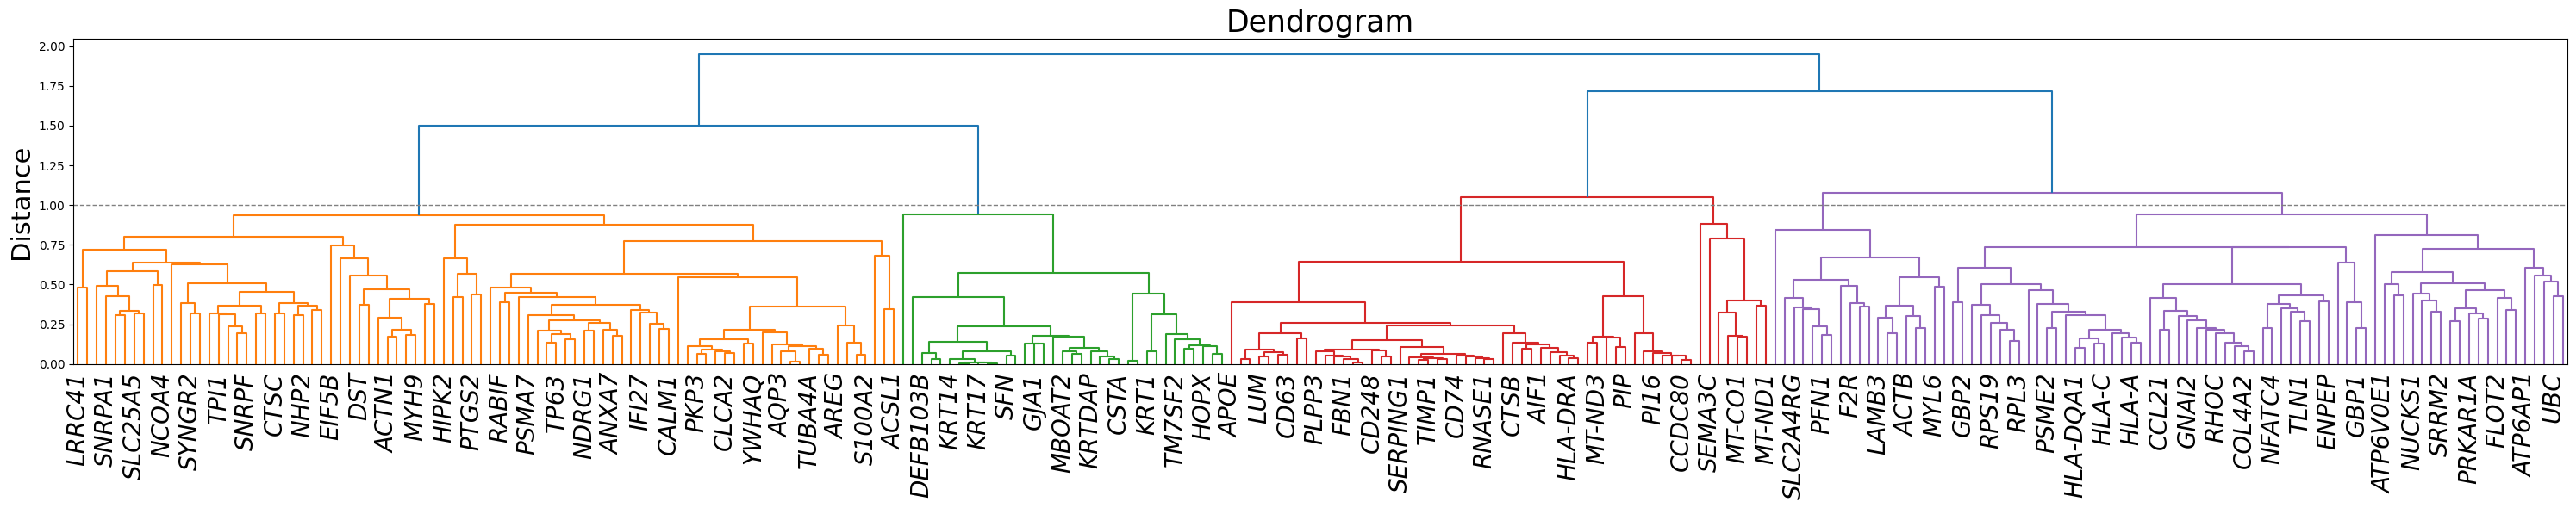

In [5]:
Z, corr, df = STAVAG.gene_modules(adata, DVG_along_y_axis)
plt.figure(figsize=(30, 6))
ax = plt.gca()
labels = ax.get_xticklabels()
dendro = dendrogram(Z, labels=corr.columns, leaf_rotation=45)
ax = plt.gca()
labels = ax.get_xticklabels()

for i, label in enumerate(labels):
    if i % 3 != 0: 
        label.set_visible(False)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title("Dendrogram", fontsize=25)
plt.ylabel("Distance", fontsize=22)
plt.xticks(fontsize=20, fontstyle='italic', rotation=90)
plt.tight_layout()
plt.show()

In [6]:
max_clusters = 6
clusters = fcluster(Z, max_clusters, criterion='maxclust')

## Visualize the gene modules on spatial data

In [7]:
plt.rcParams['figure.facecolor'] = 'white'  # Set the overall figure background to white
plt.rcParams['axes.facecolor'] = 'white'    # Set the axes background to white
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, figsize=(3.3, 3.5))  # Configure Scanpy's default figure settings

# Define a custom colormap using a list of colors
colors = ["#8ec8e1", "#219cb9", "#03314a", "#eed094", "#e18a02"]
cmap = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23020\2283339656.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Module_'+str(count)] =  mean_values


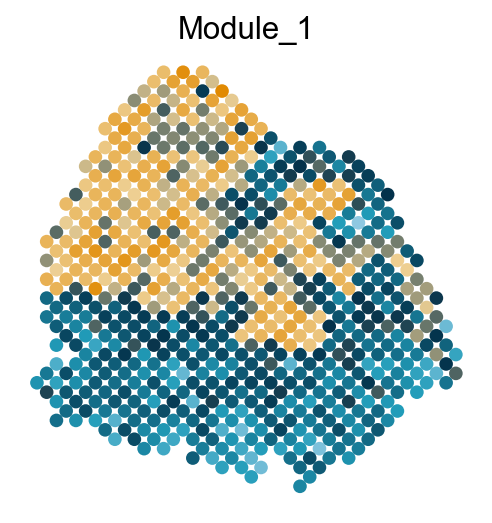

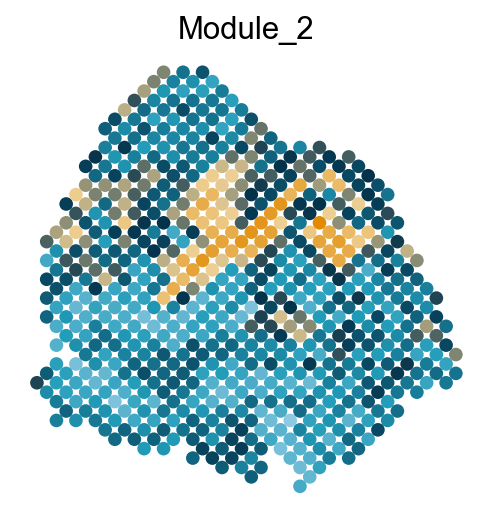

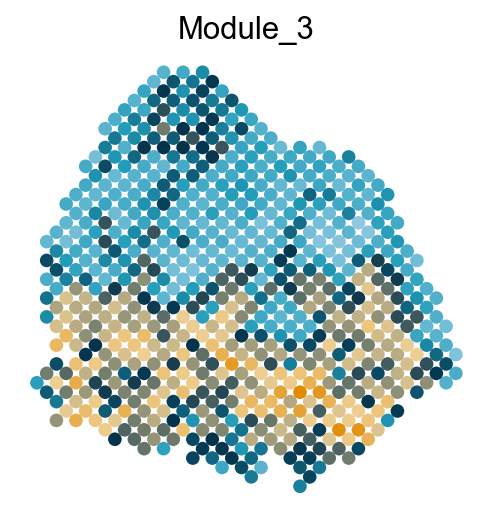

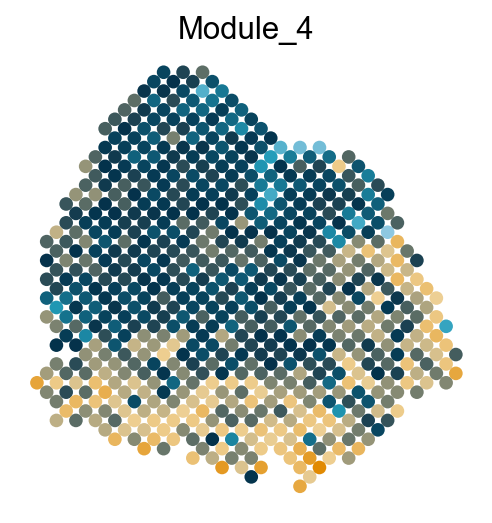

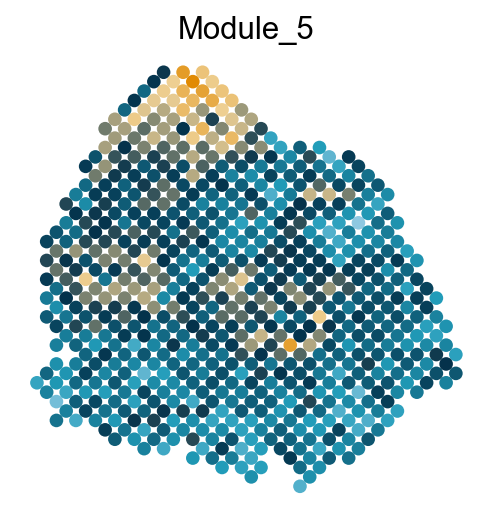

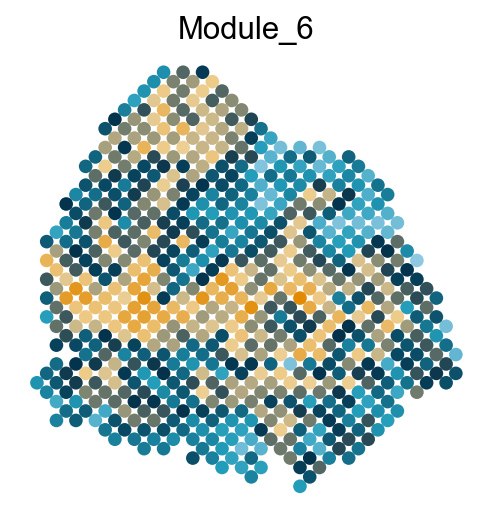

In [8]:
# Map clustering results to column names
cluster_labels = {name: cluster for name, cluster in zip(corr.columns, clusters)}

# Create an empty DataFrame for each moules to store the corresponding columns
cluster_groups = {i: pd.DataFrame() for i in np.unique(clusters)}

# Assign columns to their corresponding cluster DataFrame
for col in df.columns:
    cluster = cluster_labels[col]
    cluster_groups[cluster][col] = df[col]

# Compute the average value across columns for each module
count = 1
for cluster, data in cluster_groups.items():
    mean_values = data.mean(axis=1)
    #print(data.shape[1])
    adata.obs['Module_'+str(count)] =  mean_values
    sc.pl.embedding(adata, basis='spatial', color='Module_'+str(count), legend_loc='none', cmap=cmap, s=150, frameon=False, 
                     colorbar_loc=None, title=None, show=False)
    plt.tight_layout()
    count += 1

## Export DVGs and corresponding modules

In [9]:
gene_cluster = pd.DataFrame([DVG_along_y_axis,clusters]).T
gene_cluster.columns = ['gene', 'modules']
gene_cluster.head()
#gene_cluster.to_csv('DVGs_cSCC.csv')

,gene,modules
0,CCDC80,3
1,CFD,3
2,MT-CO1,4
3,DCD,3
4,DCN,3
